In [1]:
import numpy as np
import pandas as pd

def Peaks(x, y):
    z = 3*(1-x)**2 * np.exp(-(x**2) - (y+1)**2) - 10*(x/5 - x**3 - y**5) * np.exp(-x**2 - y**2) - 1/3 * np.exp(-(x+1)**2 - y**2)
    return z

def GetGrid(grid):
    x = np.linspace(-2, 2, grid)
    y = np.linspace(-2, 2, grid)
    x, y = np.meshgrid(x, y)
    z = Peaks(x, y)
    return x, y, z

def create_dataframe(grid):
   x, y, z = GetGrid(grid)
   data = {'x1': x.flatten(), 'x2': y.flatten(), 'f(x1,x2)': z.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Gaussian")

/tmp/ipykernel_1359668/3623673326.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


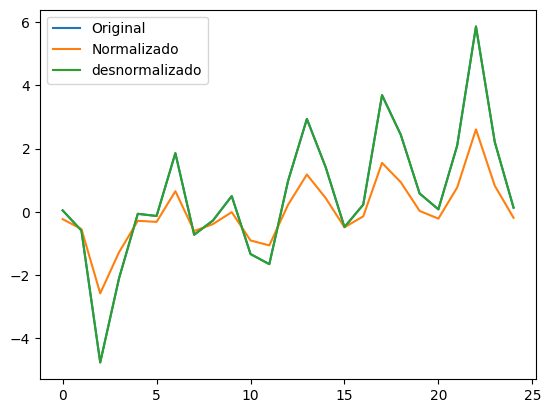

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...


remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 32.99 KiB | 16.50 MiB/s, done.


Resolving deltas: 100% (31/31), done.


In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-08-25 02:42:02.956212: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-25 02:42:03.012015: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-25 02:42:03.012052: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-25 02:42:03.013373: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-25 02:42:03.021462: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-25 02:42:03.022578: I tensorflow/core/platform/cpu_feature_guard.cc:1

2024-08-25 02:42:04.507118: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-.weights.h5')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-.weights.h5",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [8]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[12, 2]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[12, 2], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 4 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 8 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 4 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 6 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 2 ++++++++++++++++++

Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_4,0.918270,0.724880,0.655859,0.953553,0.353872,1.839730,1.230973,0.270335,1.040293,0.594871,6.230740,0.604240,132.077641,273.412814
model_1_2_3,0.915443,0.723815,0.656299,0.952441,0.366110,1.846850,1.229398,0.276806,1.050936,0.605070,6.411635,0.614599,132.009644,273.344817
model_1_2_2,0.898192,0.719249,0.618161,0.951970,0.440802,1.877384,1.365815,0.279549,1.177547,0.663929,7.515692,0.674385,131.638320,272.973492
model_1_2_1,0.896669,0.718478,0.616105,0.950764,0.447397,1.882539,1.373170,0.286570,1.181399,0.668877,7.613179,0.679412,131.608618,272.943790
model_1_2_0,0.895169,0.717298,0.612000,0.950224,0.453891,1.890426,1.387854,0.289715,1.185617,0.673714,7.709171,0.684325,131.579796,272.914969
model_1_2_5,0.925242,0.715713,0.641442,0.954184,0.323683,1.901031,1.282542,0.266666,0.976663,0.568931,5.784504,0.577891,132.255982,273.591154
model_1_2_6,0.929910,0.685620,0.584968,0.950210,0.303470,2.102264,1.484545,0.289796,1.015780,0.550881,5.485732,0.559557,132.384943,273.720116
model_1_2_7,0.930196,0.683316,0.578678,0.947594,0.302235,2.117665,1.507043,0.305018,1.014178,0.549759,5.467471,0.558417,132.393102,273.728274


DataFrame salvo em ../results/metrics_1_2


+++++++++++ [1_3] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 4 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_0,0.926563,0.651116,0.508895,0.886036,0.317966,2.332991,1.756655,0.613047,1.211920,0.563885,5.699999,0.572765,132.291622,273.626794
model_1_3_1,0.924480,0.645835,0.488601,0.873388,0.326984,2.368300,1.829246,0.681081,1.313306,0.571826,5.833306,0.580831,132.235685,273.570858
model_1_3_3,0.905389,0.631516,0.301706,0.764820,0.409642,2.464052,2.497758,1.265099,1.762750,0.640033,7.055103,0.650113,131.784944,273.120116
model_1_3_2,0.912092,0.630611,0.412101,0.811604,0.380620,2.470104,2.102882,1.013438,1.646917,0.616944,6.626112,0.626660,131.931910,273.267082
model_1_3_8,0.892543,0.625478,0.144886,0.627259,0.465263,2.504428,3.058694,2.005082,1.728730,0.682102,7.877266,0.692844,131.530304,272.865477
model_1_3_7,0.888237,0.619578,0.145976,0.618746,0.483905,2.543886,3.054794,2.050877,1.798209,0.695633,8.152814,0.706588,131.451735,272.786908
model_1_3_4,0.891801,0.616795,0.199800,0.701324,0.468475,2.562495,2.862268,1.606662,1.962912,0.684452,7.924743,0.695232,131.516545,272.851717
model_1_3_5,0.888356,0.603700,0.113880,0.675856,0.483392,2.650061,3.169600,1.743664,2.102912,0.695264,8.145238,0.706214,131.453855,272.789027
model_1_3_6,0.890440,0.602245,0.087452,0.667628,0.474366,2.659787,3.264132,1.787927,1.975707,0.688742,8.011816,0.699589,131.491553,272.826726


DataFrame salvo em ../results/metrics_1_3


+++++++++++ [1_4] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_4] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_8,0.957131,0.657464,0.202638,0.958771,0.185614,2.290543,2.852118,0.207771,1.142355,0.430829,3.743638,0.437614,133.368177,274.703350
model_1_4_4,0.937847,0.655399,0.169269,0.942601,0.269108,2.304348,2.971477,0.289258,1.413452,0.518757,4.977813,0.526926,132.625282,273.960455
model_1_4_5,0.946023,0.654423,0.157982,0.954612,0.233705,2.310876,3.011848,0.228728,1.342924,0.483431,4.454502,0.491044,132.907390,274.242563
model_1_4_7,0.953631,0.653241,0.177097,0.959576,0.200766,2.318777,2.943477,0.203714,1.215683,0.448069,3.967614,0.455126,133.211230,274.546403
model_1_4_3,0.926919,0.652899,0.217402,0.936956,0.316423,2.321065,2.799306,0.317704,1.480369,0.562515,5.677191,0.571374,132.301351,273.636524
model_1_4_2,0.918288,0.650932,0.216444,0.937477,0.353794,2.334223,2.802733,0.315078,1.560883,0.594806,6.229594,0.604174,132.078079,273.413252
model_1_4_6,0.951560,0.649312,0.161134,0.959900,0.209732,2.345050,3.000573,0.202080,1.276695,0.457966,4.100151,0.465178,133.123845,274.459018
model_1_4_9,0.953546,0.644634,0.145208,0.943153,0.201136,2.376331,3.057543,0.286474,1.084360,0.448482,3.973086,0.455545,133.207546,274.542719
model_1_4_0,0.899132,0.636021,0.155894,0.913972,0.436734,2.433927,3.019316,0.433530,1.681189,0.660859,7.455570,0.671267,131.656860,272.992033
model_1_4_1,0.905899,0.633678,0.180682,0.920020,0.407433,2.449599,2.930651,0.403051,1.571446,0.638304,7.022447,0.648357,131.795759,273.130932


DataFrame salvo em ../results/metrics_1_4


+++++++++++ [1_5] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_0,0.948235,0.644031,0.172358,0.902328,0.224130,2.380366,2.960428,0.339225,1.107129,0.473423,4.312962,0.480879,132.991061,274.326234
model_1_5_1,0.948552,0.635507,0.253825,0.878806,0.222756,2.437364,2.669024,0.420919,1.053540,0.471970,4.292660,0.479404,133.003355,274.338528
model_1_5_2,0.947315,0.629657,0.260161,0.868628,0.228114,2.476486,2.646360,0.456267,1.042321,0.477613,4.371864,0.485135,132.955815,274.290988
model_1_5_3,0.943708,0.622907,0.273042,0.842994,0.243728,2.521626,2.600285,0.545297,1.032629,0.493688,4.602657,0.501463,132.823403,274.158576
model_1_5_4,0.941417,0.620300,0.283715,0.825318,0.253648,2.539056,2.562109,0.606689,1.032755,0.503635,4.749293,0.511567,132.743612,274.078785
model_1_5_5,0.936535,0.617824,0.296987,0.791948,0.274787,2.555613,2.514636,0.722585,1.038134,0.524201,5.061751,0.532457,132.583519,273.918691
model_1_5_7,0.940132,0.609828,0.322020,0.807170,0.259214,2.609083,2.425095,0.669719,0.950447,0.509131,4.831565,0.517149,132.700200,274.035373
model_1_5_6,0.930972,0.608455,0.307553,0.753970,0.298873,2.618266,2.476844,0.854487,1.026120,0.546692,5.417771,0.555302,132.415476,273.750649
model_1_5_8,0.934342,0.602153,0.327490,0.767961,0.284281,2.660407,2.405528,0.805896,0.952695,0.533180,5.202089,0.541577,132.515583,273.850756
model_1_5_9,0.920273,0.564996,0.294565,0.655194,0.345196,2.908874,2.523299,1.197545,0.876080,0.587534,6.102505,0.596787,132.127283,273.462456


DataFrame salvo em ../results/metrics_1_5


+++++++++++ [1_6] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 10 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_3,0.926354,0.579810,0.279240,0.893898,0.318868,2.809812,2.578118,0.273784,0.871649,0.564684,5.713334,0.573577,132.285956,273.621128
model_1_6_4,0.928622,0.577087,0.275114,0.905760,0.309049,2.828019,2.592874,0.243177,0.872542,0.555922,5.568201,0.564677,132.348508,273.683680
model_1_6_1,0.922553,0.575554,0.301608,0.873421,0.335326,2.838272,2.498107,0.326622,0.867331,0.579073,5.956606,0.588193,132.185304,273.520477
model_1_6_2,0.924930,0.573849,0.296898,0.882854,0.325034,2.849677,2.514955,0.302282,0.869400,0.570118,5.804478,0.579096,132.247650,273.582822
model_1_6_0,0.920408,0.571893,0.302308,0.865034,0.344611,2.862753,2.495606,0.348267,0.875536,0.587036,6.093858,0.596281,132.130676,273.465848
model_1_6_5,0.928501,0.497331,-0.002406,0.821879,0.309571,3.361351,3.585547,0.459623,0.611574,0.556391,5.575912,0.565154,132.345135,273.680307
model_1_6_6,0.928368,0.492121,-0.015163,0.813971,0.310148,3.396190,3.631179,0.480029,0.608357,0.556909,5.584434,0.565680,132.341413,273.676586
model_1_6_7,0.928548,0.487177,-0.027473,0.808364,0.309368,3.429247,3.675213,0.494496,0.602066,0.556209,5.572913,0.564969,132.346446,273.681618
model_1_6_8,0.932554,0.354608,-0.358537,0.814594,0.292022,4.315741,4.859408,0.478420,0.539668,0.540391,5.316515,0.548902,132.461850,273.797022
model_1_6_9,0.936101,0.317318,-0.499458,0.761027,0.276666,4.565099,5.363476,0.616645,0.488325,0.525991,5.089526,0.534274,132.569888,273.905061


DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++


Stopped at epoch:  55
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 7 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_0,0.926056,0.154577,-0.135024,0.498150,0.320160,5.653347,4.059915,1.476649,0.657092,0.565827,5.732433,0.574738,132.277868,273.613040
model_1_7_1,0.922679,0.138914,-0.133150,0.468100,0.334779,5.758087,4.053212,1.565068,0.656190,0.578601,5.948520,0.587713,132.188570,273.523742
model_1_7_2,0.922420,0.128567,-0.125989,0.461556,0.335901,5.827279,4.027596,1.584324,0.650253,0.579570,5.965109,0.588698,132.181876,273.517049
model_1_7_3,0.925158,0.109465,-0.142729,0.477210,0.324047,5.955011,4.087474,1.538264,0.636175,0.569251,5.789884,0.578216,132.253734,273.588907
model_1_7_4,0.927449,0.085245,-0.189174,0.490600,0.314126,6.116972,4.253608,1.498863,0.621139,0.560469,5.643236,0.569296,132.315924,273.651096
model_1_7_5,0.932204,0.067296,-0.240991,0.522533,0.293538,6.236995,4.438954,1.404906,0.600937,0.541792,5.338923,0.550324,132.451494,273.786667
model_1_7_9,0.938526,0.046532,-0.466424,0.559968,0.266167,6.375846,5.245313,1.294754,0.526475,0.515914,4.934336,0.524039,132.647263,273.982435
model_1_7_6,0.933363,0.039353,-0.310039,0.527286,0.288521,6.423854,4.685932,1.390920,0.587661,0.537142,5.264767,0.545601,132.485972,273.821144
model_1_7_8,0.939702,0.031945,-0.402707,0.570018,0.261075,6.473389,5.017402,1.265184,0.545360,0.510955,4.859074,0.519002,132.685892,274.021065
model_1_7_7,0.938141,0.028498,-0.348588,0.560319,0.267834,6.496441,4.823821,1.293723,0.565864,0.517527,4.958983,0.525678,132.634772,273.969945


DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++


Stopped at epoch:  54
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 2 ++++++++++++++++++


Stopped at epoch:  11
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 3 ++++++++++++++++++


Stopped at epoch:  19
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 5 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 6 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 10 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_0,0.964108,-0.536457,-0.476385,0.876485,0.155404,10.274294,5.280943,0.326812,0.542492,0.394213,3.297090,0.400421,133.723461,275.058633
model_1_8_5,0.960567,-0.833936,-0.041346,0.745717,0.170736,12.263539,3.724836,0.672814,0.571370,0.413203,3.523734,0.419710,133.535268,274.870440
model_1_8_1,0.968166,-0.933046,-0.516741,0.875855,0.137835,12.926286,5.425295,0.328478,0.600549,0.371261,3.037403,0.377108,133.963394,275.298567
model_1_8_2,0.967525,-0.994895,-0.360160,0.842543,0.140609,13.339869,4.865213,0.416619,0.626124,0.374979,3.078411,0.380885,133.923539,275.258712
model_1_8_4,0.965633,-1.029431,-0.274964,0.798183,0.148799,13.570813,4.560471,0.533992,0.565502,0.385745,3.199463,0.391820,133.810320,275.145492
model_1_8_3,0.961865,-1.045166,-0.235875,0.782661,0.165116,13.676033,4.420655,0.575062,0.601664,0.406344,3.440651,0.412744,133.602217,274.937389
model_1_8_6,0.964418,-1.086743,-0.257446,0.773517,0.154059,13.954059,4.497811,0.599257,0.588305,0.392504,3.277219,0.398685,133.740837,275.076010
model_1_8_7,0.960631,-1.151457,-0.177760,0.733621,0.170457,14.386803,4.212779,0.704817,0.574471,0.412864,3.519604,0.419367,133.538543,274.873716
model_1_8_8,0.961659,-1.276415,-0.232950,0.741685,0.166009,15.222399,4.410192,0.683482,0.562357,0.407442,3.453850,0.413858,133.591430,274.926603
model_1_8_9,0.964421,-1.335018,-0.296120,0.754960,0.154050,15.614279,4.636145,0.648356,0.534415,0.392492,3.277085,0.398674,133.740954,275.076127


DataFrame salvo em ../results/metrics_1_8


+++++++++++ [1_9] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_4,0.968012,-1.215707,-0.414879,0.923269,0.138501,14.816440,5.060940,0.464484,0.412355,0.372157,3.047249,0.378019,133.953753,275.288925
model_1_9_5,0.967774,-1.224471,-0.448942,0.917830,0.139530,14.875051,5.182782,0.497413,0.414749,0.373537,3.062460,0.379420,133.938948,275.274120
model_1_9_3,0.967491,-1.226560,-0.389404,0.926644,0.140756,14.889015,4.969819,0.444055,0.414739,0.375175,3.080580,0.381083,133.921453,275.256626
model_1_9_6,0.967531,-1.245499,-0.480438,0.913000,0.140584,15.015661,5.295440,0.526651,0.412940,0.374945,3.078030,0.380850,133.923906,275.259078
model_1_9_2,0.966725,-1.255157,-0.374914,0.929935,0.144074,15.080244,4.917987,0.424136,0.419507,0.379571,3.129624,0.385549,133.874856,275.210028
model_1_9_7,0.967415,-1.275985,-0.516411,0.909273,0.141085,15.219523,5.424115,0.549210,0.403449,0.375613,3.085442,0.381528,133.916785,275.251958
model_1_9_1,0.965468,-1.276722,-0.345354,0.932391,0.149515,15.224450,4.812254,0.409268,0.434084,0.386671,3.210045,0.392761,133.800721,275.135893
model_1_9_8,0.967907,-1.295350,-0.539795,0.908120,0.138954,15.349016,5.507758,0.556190,0.392288,0.372765,3.053938,0.378636,133.947229,275.282402
model_1_9_9,0.969132,-1.311364,-0.562791,0.909822,0.133649,15.456104,5.590012,0.545889,0.376753,0.365581,2.975529,0.371338,134.025074,275.360247
model_1_9_0,0.962684,-1.311402,-0.312904,0.930340,0.161569,15.456357,4.696183,0.421685,0.447358,0.401957,3.388231,0.408287,133.645641,274.980813


DataFrame salvo em ../results/metrics_1_9


+++++++++++ [1_10] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 2 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 3 ++++++++++++++++++


Stopped at epoch:  18
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 5 ++++++++++++++++++


Stopped at epoch:  11
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_4,0.931211,-1.183089,-0.401685,-0.657162,0.297838,14.598328,5.013746,1.236817,0.923357,0.545746,5.402482,0.554340,132.422410,273.757582
model_1_10_2,0.946753,-1.242601,-0.477921,-0.051869,0.230544,14.996282,5.286438,0.785059,0.575206,0.480150,4.407779,0.487712,132.934625,274.269798
model_1_10_3,0.934652,-1.268073,-0.459857,-0.471655,0.282942,15.166612,5.221823,1.098365,0.691900,0.531923,5.182299,0.540300,132.525024,273.860197
model_1_10_0,0.968791,-1.275843,-0.520890,0.904651,0.135126,15.218576,5.440134,0.071164,0.406931,0.367595,2.997360,0.373384,134.003094,275.338266
model_1_10_1,0.940149,-1.277142,-0.472310,-0.109264,0.259138,15.227262,5.266369,0.827896,0.674707,0.509056,4.830442,0.517073,132.700787,274.035959
model_1_10_5,0.911452,-1.376669,-0.485601,-1.262440,0.383391,15.892795,5.313910,1.688565,1.080876,0.619186,6.667081,0.628938,131.917398,273.252571
model_1_10_6,0.896859,-1.514534,-0.534506,-1.738933,0.446576,16.814704,5.488841,2.044194,1.152342,0.668263,7.601045,0.678788,131.612291,272.947463
model_1_10_7,0.887755,-1.577349,-0.554570,-2.033647,0.485991,17.234748,5.560608,2.264153,1.348123,0.697131,8.183657,0.708110,131.443129,272.778302


DataFrame salvo em ../results/metrics_1_10
+++++++++++ [1_11] | 1 ++++++++++++++++++


Stopped at epoch:  25
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 4 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 10 ++++++++++++++++++

Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 1 ++++++++++++++++++


Stopped at epoch:  16
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 4 ++++++++++++++++++


Stopped at epoch:  11
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 5 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 6 ++++++++++++++++++


Stopped at epoch:  18
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 8 ++++++++++++++++++


Stopped at epoch:  15
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_7,0.923801,0.151718,0.202681,0.361705,0.329924,5.672466,2.851965,0.987745,0.582786,0.574390,5.876758,0.583436,132.217785,273.552958
model_1_12_6,0.922972,0.148309,0.202214,0.364203,0.333512,5.695264,2.853635,0.983879,0.610205,0.577505,5.929794,0.586600,132.196152,273.531325
model_1_12_5,0.922531,0.144905,0.206106,0.380854,0.335421,5.718023,2.839712,0.958112,0.618691,0.579156,5.958012,0.588277,132.184737,273.519910
model_1_12_4,0.919169,-0.004711,0.063827,0.485471,0.349978,6.718507,3.348637,0.796221,0.808710,0.591589,6.173178,0.600906,132.099772,273.434945
model_1_12_3,0.925298,-0.012312,0.119226,0.653945,0.323442,6.769335,3.150479,0.535511,0.776003,0.568720,5.780949,0.577677,132.257468,273.592641
model_1_12_2,0.922009,-0.251664,-0.036506,0.819653,0.337681,8.369882,3.707521,0.279082,0.776588,0.581103,5.991418,0.590255,132.171307,273.506479
model_1_12_1,0.919860,-0.282513,-0.028982,0.879608,0.346984,8.576172,3.680609,0.186303,0.773379,0.589054,6.128935,0.598331,132.116950,273.452123
model_1_12_0,0.903370,-0.493674,-0.207814,0.955533,0.418386,9.988206,4.320280,0.068811,0.761011,0.646827,7.184347,0.657014,131.742704,273.077876


DataFrame salvo em ../results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++


Stopped at epoch:  13
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 8 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_3,0.890291,0.398871,0.510889,0.548994,0.475013,4.019755,1.749521,1.704440,0.911677,0.689212,8.021378,0.700066,131.488828,272.824000
model_1_13_2,0.895438,0.342558,0.374254,0.650686,0.452726,4.396315,2.238256,1.320124,0.784913,0.672850,7.691956,0.683446,131.584934,272.920107
model_1_13_1,0.916223,0.228316,0.268731,0.808012,0.362733,5.160254,2.615708,0.725559,0.668117,0.602273,6.361714,0.611758,132.028179,273.363352
model_1_13_0,0.919333,0.210243,0.249764,0.828019,0.349269,5.281110,2.683551,0.649950,0.658054,0.590990,6.162709,0.600298,132.103824,273.438996


DataFrame salvo em ../results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++


Stopped at epoch:  18
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 6 ++++++++++++++++++

Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 10 ++++++++++++++++++


Stopped at epoch:  45
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 1 ++++++++++++++++++


Stopped at epoch:  19
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 2 ++++++++++++++++++

Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 3 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 7 ++++++++++++++++++


Stopped at epoch:  26
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 9 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 10 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 1 ++++++++++++++++++


Stopped at epoch:  27
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 2 ++++++++++++++++++


Stopped at epoch:  14
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 1 ++++++++++++++++++


Stopped at epoch:  13
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 2 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 10 ++++++++++++++++++

Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_17_1,0.900923,0.691896,0.759230,0.826388,0.428978,2.060293,0.861219,0.581647,1.596928,0.654964,7.340925,0.665279,131.692697,273.027870
model_1_17_2,0.886018,0.687724,0.675077,0.689093,0.493513,2.088191,1.162230,1.041620,1.656844,0.702505,8.294846,0.713569,131.412410,272.747583
model_1_17_0,0.891503,0.675581,0.753161,0.815903,0.469764,2.169390,0.882928,0.616774,1.602022,0.685393,7.943788,0.696187,131.511052,272.846224
model_1_17_3,0.885383,0.641065,0.302441,0.514043,0.496262,2.400200,2.495129,1.628085,1.574692,0.704458,8.335468,0.715553,131.401304,272.736477
model_1_17_4,0.885139,0.638570,0.299636,0.510140,0.497319,2.416885,2.505162,1.641161,1.569701,0.705208,8.351097,0.716315,131.397048,272.732220


DataFrame salvo em ../results/metrics_1_17
+++++++++++ [1_18] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 2 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 6 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 7 ++++++++++++++++++


Stopped at epoch:  14
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_18_8,0.932134,0.658529,0.600812,0.771020,0.293841,2.283416,1.427871,0.512092,1.283513,0.542071,5.343404,0.550608,132.449430,273.784603
model_1_18_7,0.926893,0.651273,0.567298,0.740026,0.316536,2.331941,1.547748,0.581406,1.275551,0.562616,5.678869,0.571476,132.300634,273.635806
model_1_18_6,0.925528,0.647985,0.557559,0.733274,0.322447,2.353925,1.582584,0.596507,1.288899,0.567844,5.766233,0.576787,132.263634,273.598807
model_1_18_5,0.916589,0.647626,0.511233,0.691539,0.361147,2.356327,1.748292,0.689844,1.362299,0.600955,6.338280,0.610420,132.036940,273.372112
model_1_18_4,0.903215,0.645156,0.464578,0.630226,0.419054,2.372843,1.915173,0.826965,1.389137,0.647344,7.194233,0.657539,131.739509,273.074682
model_1_18_2,0.893936,0.617755,0.460545,0.658689,0.459229,2.556071,1.929598,0.763310,1.472201,0.677665,7.788077,0.688337,131.556411,272.891584
model_1_18_1,0.892889,0.617491,0.459098,0.649539,0.463764,2.557841,1.934776,0.783773,1.448894,0.681002,7.855104,0.691727,131.536760,272.871932
model_1_18_3,0.892060,0.616679,0.471110,0.624918,0.467354,2.563268,1.891807,0.838835,1.452341,0.683633,7.908173,0.694400,131.521336,272.856509
model_1_18_0,0.891934,0.616095,0.457901,0.652923,0.467900,2.567172,1.939055,0.776205,1.422540,0.684032,7.916238,0.694805,131.519003,272.854175


DataFrame salvo em ../results/metrics_1_18


+++++++++++ [1_19] | 1 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 7 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 9 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_19_0,0.944682,0.675569,0.683522,0.968951,0.239514,2.169471,1.132023,0.143782,1.062201,0.489402,4.540370,0.497110,132.858284,274.193457
model_1_19_2,0.944766,0.671290,0.678255,0.944597,0.239152,2.198083,1.150862,0.256560,1.341461,0.489031,4.535007,0.496733,132.861316,274.196488
model_1_19_1,0.941077,0.669338,0.673191,0.940043,0.255121,2.211142,1.168978,0.277650,1.321715,0.505096,4.771067,0.513050,132.732031,274.067203
model_1_19_4,0.942655,0.664124,0.650492,0.917191,0.248288,2.246002,1.250171,0.383475,1.534431,0.498285,4.670052,0.506132,132.786335,274.121508
model_1_19_3,0.943362,0.663881,0.657637,0.923784,0.245229,2.247630,1.224613,0.352944,1.503704,0.495206,4.624838,0.503005,132.811128,274.146300
model_1_19_5,0.932325,0.648259,0.574326,0.851097,0.293016,2.352091,1.522610,0.689542,1.826482,0.541309,5.331198,0.549834,132.455059,273.790231
model_1_19_6,0.927016,0.630474,0.497882,0.799419,0.316002,2.471023,1.796048,0.928854,1.962923,0.562140,5.670968,0.570994,132.304014,273.639187
model_1_19_7,0.918854,0.609847,0.446485,0.745817,0.351340,2.608958,1.979890,1.177074,2.111348,0.592740,6.193324,0.602075,132.091999,273.427171
model_1_19_8,0.933905,0.593463,0.458194,0.800176,0.286173,2.718514,1.938010,0.925348,1.955180,0.534952,5.230059,0.543377,132.502315,273.837487
model_1_19_9,0.930593,0.570449,0.405854,0.770813,0.300514,2.872409,2.125226,1.061322,2.005982,0.548192,5.442038,0.556825,132.404520,273.739693


DataFrame salvo em ../results/metrics_1_19
+++++++++++ [1_20] | 1 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 2 ++++++++++++++++++


Stopped at epoch:  14
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 5 ++++++++++++++++++


Stopped at epoch:  13
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 6 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 7 ++++++++++++++++++


Stopped at epoch:  23
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 9 ++++++++++++++++++


Stopped at epoch:  30
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 10 ++++++++++++++++++


Stopped at epoch:  66
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_20_9,0.949384,0.693127,0.778042,0.604007,0.219155,2.052060,0.793932,1.059019,0.674139,0.468140,4.239427,0.475512,133.035954,274.371126
model_1_20_8,0.930010,0.675392,0.768392,0.478069,0.303037,2.170655,0.828448,1.395820,0.879165,0.550488,5.479333,0.559158,132.387798,273.722971
model_1_20_6,0.929706,0.652541,0.786499,0.511696,0.304354,2.323460,0.763680,1.305891,1.144790,0.551683,5.498793,0.560371,132.379128,273.714301
model_1_20_7,0.929382,0.651328,0.785985,0.507885,0.305758,2.331569,0.765521,1.316084,1.137936,0.552954,5.519550,0.561662,132.369922,273.705094
model_1_20_4,0.945031,0.642580,0.662066,0.697804,0.238001,2.390067,1.208771,0.808175,1.442079,0.487854,4.518002,0.495537,132.870960,274.206133
model_1_20_5,0.934740,0.635282,0.679386,0.595254,0.282559,2.438871,1.146818,1.082429,1.428978,0.531563,5.176636,0.539935,132.527734,273.862907
model_1_20_3,0.949744,0.633766,0.609881,0.769961,0.217597,2.449010,1.395433,0.615201,1.505070,0.466473,4.216399,0.473819,133.050222,274.385394
model_1_20_2,0.949701,0.632860,0.610411,0.775883,0.217781,2.455068,1.393537,0.599365,1.513753,0.466671,4.219125,0.474020,133.048527,274.383700
model_1_20_1,0.948183,0.621677,0.570157,0.788267,0.224354,2.529846,1.537522,0.566245,1.581241,0.473660,4.316277,0.481120,132.989061,274.324234
model_1_20_0,0.941685,0.608753,0.519098,0.766159,0.252488,2.616270,1.720158,0.625369,1.714597,0.502482,4.732136,0.510395,132.752785,274.087958


DataFrame salvo em ../results/metrics_1_20


+++++++++++ [1_21] | 1 ++++++++++++++++++


Stopped at epoch:  68
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 7ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 7 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_21_8,0.963087,0.585777,0.465022,0.788235,0.159824,2.769910,1.913585,0.694436,0.860573,0.399780,3.362428,0.406076,133.667367,275.002539
model_1_21_9,0.964900,0.582250,0.492987,0.795944,0.151975,2.793496,1.813554,0.669155,0.793876,0.389839,3.246405,0.395979,133.768084,275.103257
model_1_21_7,0.963806,0.575632,0.403913,0.796943,0.156712,2.837749,2.132169,0.665881,0.870487,0.395869,3.316433,0.402103,133.706689,275.041862
model_1_21_1,0.968175,0.567295,0.383563,0.862663,0.137793,2.893498,2.204959,0.450365,0.741543,0.371204,3.036775,0.377050,133.964011,275.299184
model_1_21_6,0.966581,0.566354,0.363898,0.819545,0.144698,2.899791,2.275299,0.591763,0.839323,0.380391,3.138842,0.386382,133.866217,275.201390
model_1_21_0,0.968452,0.564429,0.403666,0.876405,0.136595,2.912668,2.133053,0.405303,0.711532,0.369588,3.019076,0.375409,133.981466,275.316639
model_1_21_5,0.967294,0.558308,0.329602,0.830758,0.141607,2.953599,2.397976,0.554992,0.834316,0.376307,3.093153,0.382233,133.909404,275.244577
model_1_21_4,0.968540,0.552929,0.310074,0.844680,0.136212,2.989563,2.467825,0.509336,0.796444,0.369069,3.013410,0.374881,133.987087,275.322260
model_1_21_2,0.969441,0.543935,0.305035,0.859562,0.132314,3.049711,2.485848,0.460536,0.763979,0.363749,2.955788,0.369478,134.045160,275.380333
model_1_21_3,0.969408,0.543530,0.303305,0.858150,0.132455,3.052417,2.492039,0.465165,0.766312,0.363944,2.957877,0.369675,134.043025,275.378198


DataFrame salvo em ../results/metrics_1_21
+++++++++++ [1_22] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 10 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_22_7,0.946501,0.669717,0.712780,0.807930,0.231638,2.208605,1.027368,0.787179,0.974954,0.481288,4.423951,0.488868,132.925156,274.260329
model_1_22_8,0.944873,0.669393,0.717336,0.798216,0.238685,2.210773,1.011072,0.826988,0.983122,0.488554,4.528111,0.496248,132.865221,274.200394
model_1_22_9,0.945464,0.668716,0.720087,0.796817,0.236126,2.215294,1.001234,0.832723,0.947561,0.485928,4.490291,0.493581,132.886777,274.221949
model_1_22_2,0.957786,0.667004,0.628273,0.898571,0.182778,2.226746,1.329647,0.415696,0.901553,0.427525,3.701724,0.434258,133.398967,274.734139
model_1_22_3,0.958582,0.665193,0.623048,0.898167,0.179329,2.238855,1.348335,0.417350,0.861432,0.423473,3.650746,0.430142,133.437065,274.772237
model_1_22_6,0.949152,0.664950,0.696938,0.828240,0.220159,2.240481,1.084035,0.703941,0.872305,0.469211,4.254275,0.476601,133.026808,274.361980
model_1_22_4,0.954681,0.659546,0.623902,0.873211,0.196218,2.276616,1.345281,0.519630,0.874505,0.442965,3.900393,0.449942,133.257054,274.592227
model_1_22_5,0.953944,0.656382,0.627835,0.867067,0.199411,2.297774,1.331214,0.544811,0.856235,0.446554,3.947580,0.453587,133.224778,274.559950
model_1_22_1,0.962389,0.613061,0.569905,0.937360,0.162847,2.587462,1.538423,0.256725,0.876429,0.403543,3.407110,0.409898,133.629893,274.965066
model_1_22_0,0.965050,0.598594,0.540888,0.967738,0.151324,2.684204,1.642215,0.132220,0.786104,0.389004,3.236795,0.395131,133.776659,275.111831


DataFrame salvo em ../results/metrics_1_22


+++++++++++ [1_23] | 1 ++++++++++++++++++


Stopped at epoch:  142
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 2 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 5 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 6 ++++++++++++++++++


Stopped at epoch:  11
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 10 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_23_0,0.981176,0.687944,0.718982,0.895805,0.081501,2.086722,1.005184,0.341276,0.396794,0.285484,2.204708,0.289980,135.014273,276.349445
model_1_23_1,0.980334,0.685442,0.720856,0.886448,0.085149,2.103448,0.998481,0.371923,0.381684,0.291802,2.258621,0.296398,134.926713,276.261886
model_1_23_2,0.980084,0.684001,0.722517,0.882715,0.086231,2.113086,0.992542,0.384149,0.366075,0.293651,2.274619,0.298276,134.901452,276.236625
model_1_23_3,0.979736,0.681233,0.724867,0.878588,0.087740,2.131598,0.984134,0.397668,0.348100,0.296210,2.296928,0.300875,134.866750,276.201923
model_1_23_4,0.979050,0.677816,0.723224,0.871953,0.090708,2.154445,0.990011,0.419398,0.330060,0.301177,2.340789,0.305920,134.800230,276.135403
model_1_23_5,0.978674,0.674392,0.724965,0.867327,0.092336,2.177340,0.983785,0.434549,0.304938,0.303869,2.364867,0.308655,134.764633,276.099806
model_1_23_6,0.978454,0.672922,0.735106,0.864794,0.093288,2.187175,0.947509,0.442847,0.290917,0.305431,2.378930,0.310241,134.744131,276.079304
model_1_23_7,0.978270,0.670337,0.745833,0.862705,0.094087,2.204457,0.909139,0.449690,0.280267,0.306736,2.390744,0.311567,134.727069,276.062242
model_1_23_8,0.977718,0.668555,0.752479,0.858194,0.096475,2.216376,0.885370,0.464465,0.270879,0.310605,2.426047,0.315497,134.676934,276.012107
model_1_23_9,0.978031,0.666964,0.774587,0.859468,0.095120,2.227015,0.806289,0.460292,0.258783,0.308416,2.406015,0.313273,134.705228,276.040401


DataFrame salvo em ../results/metrics_1_23
+++++++++++ [1_24] | 1 ++++++++++++++++++


Stopped at epoch:  25
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 2 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_24_5,0.956589,0.718444,0.494403,0.842377,0.187957,1.882767,1.808493,0.773863,0.465841,0.433540,3.778281,0.440368,133.343082,274.678254
model_1_24_4,0.964371,0.718026,0.588740,0.880304,0.154263,1.885562,1.471053,0.587657,0.474063,0.392763,3.280234,0.398949,133.738191,275.073363
model_1_24_3,0.967537,0.715749,0.698004,0.899732,0.140556,1.900790,1.080223,0.492272,0.462648,0.374908,3.077624,0.380813,133.924297,275.259469
model_1_24_6,0.953065,0.715053,0.486114,0.826314,0.203218,1.905443,1.838140,0.852727,0.464265,0.450797,4.003860,0.457897,133.186950,274.522123
model_1_24_7,0.944081,0.714505,0.461238,0.782588,0.242117,1.909106,1.927119,1.067400,0.443317,0.492054,4.578841,0.499803,132.836669,274.171841
model_1_24_2,0.970937,0.707112,0.802208,0.920478,0.125834,1.958546,0.707491,0.390418,0.432141,0.354731,2.860008,0.360317,134.145585,275.480757
model_1_24_1,0.971762,0.704946,0.809523,0.930307,0.122265,1.973030,0.681324,0.342162,0.446556,0.349664,2.807250,0.355170,134.203134,275.538307
model_1_24_8,0.928849,0.704223,0.394943,0.712705,0.308065,1.977862,2.164253,1.410496,0.442434,0.555036,5.553644,0.563777,132.354891,273.690064
model_1_24_9,0.922123,0.700726,0.361799,0.680173,0.337187,2.001248,2.282809,1.570214,0.445295,0.580678,5.984121,0.589824,132.174232,273.509405
model_1_24_0,0.980163,0.700517,0.818127,0.979737,0.085889,2.002645,0.650550,0.099482,0.324864,0.293069,2.269568,0.297684,134.909393,276.244565


DataFrame salvo em ../results/metrics_1_24
+++++++++++ [1_25] | 1 ++++++++++++++++++


Stopped at epoch:  16
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 3 ++++++++++++++++++


Stopped at epoch:  25
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_25_3,0.956539,0.731638,0.665042,0.960394,0.188176,1.794541,1.198125,0.279198,0.641758,0.433793,3.781515,0.440624,133.340755,274.675928
model_1_25_4,0.960822,0.731507,0.671069,0.960576,0.169629,1.795415,1.176568,0.277912,0.594139,0.411861,3.507366,0.418347,133.548281,274.883453
model_1_25_8,0.967351,0.729412,0.739052,0.943645,0.141362,1.809425,0.933396,0.397265,0.580017,0.375981,3.089531,0.381902,133.912867,275.248040
model_1_25_9,0.967163,0.727996,0.741314,0.942165,0.142176,1.818889,0.925305,0.407698,0.579199,0.377062,3.101565,0.383000,133.901382,275.236554
model_1_25_5,0.962547,0.727657,0.683030,0.956514,0.162163,1.821158,1.133782,0.306547,0.594250,0.402695,3.397011,0.409037,133.638302,274.973474
model_1_25_6,0.964896,0.726590,0.703137,0.954056,0.151991,1.828294,1.061861,0.323872,0.567873,0.389860,3.246645,0.396000,133.767871,275.103043
model_1_25_7,0.965877,0.725041,0.721365,0.946847,0.147743,1.838651,0.996660,0.374693,0.592365,0.384374,3.183861,0.390427,133.824558,275.159730
model_1_25_1,0.936927,0.723369,0.478746,0.988341,0.273091,1.849833,1.864496,0.082189,0.485766,0.522581,5.036675,0.530811,132.595904,273.931076
model_1_25_0,0.936100,0.722320,0.470641,0.989421,0.276669,1.856847,1.893488,0.074576,0.487379,0.525993,5.089571,0.534277,132.569867,273.905039
model_1_25_2,0.951183,0.719419,0.593582,0.962323,0.211366,1.876244,1.453733,0.265599,0.581144,0.459746,4.124303,0.466987,133.108324,274.443497


DataFrame salvo em ../results/metrics_1_25
+++++++++++ [1_26] | 1 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 2 ++++++++++++++++++


Stopped at epoch:  15
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 3 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 5 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 8 ++++++++++++++++++


Stopped at epoch:  11
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 9 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 10 ++++++++++++++++++


Stopped at epoch:  23
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_26_1,0.975878,0.723441,0.743045,0.982364,0.104440,1.849352,0.919111,0.079997,0.661299,0.323172,2.543779,0.328262,134.518280,275.853453
model_1_26_0,0.969484,0.722342,0.787555,0.990580,0.132126,1.856702,0.759902,0.042731,0.627004,0.363492,2.953016,0.369216,134.047997,275.383170
model_1_26_9,0.985797,0.716571,0.567184,0.955050,0.061495,1.895292,1.548159,0.203894,0.421503,0.247983,1.908991,0.251888,135.577586,276.912758
model_1_26_7,0.984081,0.713321,0.646994,0.967357,0.068926,1.917021,1.262681,0.148069,0.581042,0.262537,2.018826,0.266672,135.349446,276.684618
model_1_26_8,0.984777,0.710889,0.588496,0.964481,0.065911,1.933288,1.471926,0.161116,0.515916,0.256732,1.974266,0.260775,135.438888,276.774061
model_1_26_2,0.980827,0.708811,0.692676,0.981652,0.083016,1.947179,1.099281,0.083226,0.629662,0.288124,2.227091,0.292662,134.977454,276.312626
model_1_26_3,0.981084,0.707491,0.694523,0.981618,0.081903,1.956009,1.092674,0.083382,0.625795,0.286187,2.210647,0.290694,135.004437,276.339610
model_1_26_5,0.983607,0.706896,0.657656,0.978738,0.070978,1.959991,1.224544,0.096444,0.632664,0.266416,2.049153,0.270612,135.290781,276.625954
model_1_26_6,0.983661,0.706396,0.654150,0.976816,0.070744,1.963332,1.237086,0.105164,0.626789,0.265977,2.045693,0.270165,135.297387,276.632560
model_1_26_4,0.984094,0.705405,0.680789,0.984487,0.068868,1.969959,1.141801,0.070368,0.580265,0.262427,2.017972,0.266560,135.351123,276.686295


DataFrame salvo em ../results/metrics_1_26

+++++++++++ [1_27] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 3 ++++++++++++++++++


Stopped at epoch:  23
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 4 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 5 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 6 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 10 ++++++++++++++++++


Stopped at epoch:  17
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_27_0,0.988103,0.704665,0.568489,0.925812,0.051509,1.974904,1.543491,0.079392,0.397747,0.226957,1.761385,0.230531,135.931980,277.267152
model_1_27_2,0.981739,0.694001,0.615079,0.724717,0.079066,2.046219,1.376840,0.294591,0.667705,0.281186,2.168706,0.285615,135.074952,276.410125
model_1_27_9,0.984181,0.682514,0.740681,0.716046,0.068491,2.123031,0.927569,0.303870,0.606629,0.261708,2.012397,0.265830,135.362105,276.697278
model_1_27_3,0.981988,0.680057,0.616904,0.713354,0.077986,2.139462,1.370311,0.306751,0.678806,0.279260,2.152749,0.283658,135.102448,276.437621
model_1_27_8,0.984017,0.671834,0.708136,0.721080,0.069202,2.194450,1.043980,0.298483,0.579158,0.263063,2.022905,0.267206,135.341454,276.676626
model_1_27_4,0.985214,0.670974,0.644712,0.767514,0.064021,2.200202,1.270846,0.248793,0.457062,0.253023,1.946318,0.257008,135.497099,276.832272
model_1_27_1,0.978462,0.670251,0.494418,0.713320,0.093252,2.205036,1.808438,0.306787,0.823572,0.305372,2.378401,0.310181,134.744898,276.080071
model_1_27_7,0.984074,0.669167,0.697462,0.726998,0.068958,2.212281,1.082161,0.292150,0.583903,0.262598,2.019296,0.266734,135.348523,276.683695
model_1_27_6,0.984467,0.667389,0.695058,0.736073,0.067254,2.224171,1.090760,0.282439,0.559964,0.259334,1.994116,0.263419,135.398549,276.733721
model_1_27_5,0.983824,0.663713,0.677641,0.729497,0.070038,2.248753,1.153058,0.289475,0.584424,0.264647,2.035266,0.268815,135.317430,276.652602


DataFrame salvo em ../results/metrics_1_27


+++++++++++ [1_28] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 2 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 3 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 4 ++++++++++++++++++


Stopped at epoch:  77
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 5 ++++++++++++++++++


Stopped at epoch:  540
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 6 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 8 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_28_3,0.994166,0.710632,0.760002,0.959897,0.025258,1.935008,0.858457,0.090545,0.226582,0.158928,1.373351,0.161431,137.357221,278.692394
model_1_28_4,0.988569,0.698773,0.692774,0.890945,0.049494,2.014303,1.098929,0.246225,0.302137,0.222473,1.731597,0.225977,136.011799,277.346971
model_1_28_5,0.988646,0.698499,0.686927,0.891644,0.049161,2.016138,1.119845,0.244645,0.298605,0.221724,1.726678,0.225216,136.025291,277.360463
model_1_28_6,0.988705,0.698325,0.682647,0.892190,0.048904,2.017300,1.135153,0.243413,0.297265,0.221143,1.722876,0.224626,136.035782,277.370955
model_1_28_8,0.988806,0.698291,0.671391,0.893095,0.048468,2.017529,1.175415,0.241371,0.290850,0.220156,1.716435,0.223623,136.053683,277.388855
model_1_28_7,0.988729,0.698040,0.676893,0.892390,0.048799,2.019205,1.155736,0.242962,0.295225,0.220905,1.721320,0.224384,136.040091,277.375263
model_1_28_9,0.988797,0.697815,0.667707,0.892991,0.048505,2.020715,1.188593,0.241605,0.289651,0.220239,1.716979,0.223708,136.052165,277.387338
model_1_28_2,0.990636,0.691506,0.672671,0.963825,0.040544,2.062898,1.170837,0.081677,0.309525,0.201355,1.599298,0.204526,136.410739,277.745912
model_1_28_0,0.984204,0.687108,0.753128,0.945385,0.068394,2.092311,0.883045,0.123309,0.604730,0.261523,2.010964,0.265641,135.364939,276.700111
model_1_28_1,0.984865,0.686253,0.751622,0.944482,0.065532,2.098026,0.888435,0.125348,0.585585,0.255991,1.968651,0.260023,135.450449,276.785621


DataFrame salvo em ../results/metrics_1_28


+++++++++++ [1_29] | 1 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 3 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 6 ++++++++++++++++++


Stopped at epoch:  205
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 7 ++++++++++++++++++


Stopped at epoch:  25
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 36ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 8 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 9 ++++++++++++++++++


Stopped at epoch:  14
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 10 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_29_9,0.979568,0.762885,0.841842,0.839078,0.088464,1.585589,0.565723,0.441652,0.407042,0.297428,2.307621,0.302113,134.850328,276.185501
model_1_29_8,0.979606,0.762418,0.840821,0.839403,0.088303,1.588710,0.569375,0.440758,0.410252,0.297158,2.305245,0.301838,134.853965,276.189138
model_1_29_6,0.979640,0.761724,0.839889,0.839768,0.088153,1.593353,0.572709,0.439758,0.416143,0.296905,2.303025,0.301581,134.857370,276.192542
model_1_29_7,0.979612,0.761723,0.840348,0.839511,0.088275,1.593360,0.571065,0.440464,0.413730,0.297111,2.304832,0.301790,134.854598,276.189771
model_1_29_5,0.979647,0.760381,0.839423,0.839974,0.088125,1.602335,0.574374,0.439194,0.413346,0.296858,2.302611,0.301533,134.858005,276.193178
model_1_29_4,0.985703,0.720616,0.744879,0.915000,0.061904,1.868239,0.912554,0.233283,0.414126,0.248806,1.915038,0.252724,135.564326,276.899499
model_1_29_3,0.986542,0.720528,0.738798,0.922228,0.058270,1.868829,0.934305,0.213447,0.398727,0.241391,1.861312,0.245193,135.685344,277.020516
model_1_29_2,0.988877,0.718758,0.718101,0.943058,0.048159,1.880669,1.008335,0.156278,0.339348,0.219452,1.711866,0.222909,136.066479,277.401651
model_1_29_1,0.988710,0.710283,0.680386,0.947445,0.048883,1.937338,1.143242,0.144238,0.267715,0.221095,1.722561,0.224577,136.036654,277.371826
model_1_29_0,0.988883,0.708793,0.677870,0.949571,0.048135,1.947301,1.152242,0.138403,0.268970,0.219398,1.711511,0.222853,136.067476,277.402648


DataFrame salvo em ../results/metrics_1_29


+++++++++++ [1_30] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 7ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_30_0,0.979872,0.762714,0.840946,0.993783,0.087151,1.586735,0.568928,0.031558,0.400920,0.295213,2.288218,0.299863,134.880227,276.215400
model_1_30_1,0.979978,0.760708,0.837474,0.992593,0.086690,1.600144,0.581347,0.037597,0.402763,0.294432,2.281405,0.299069,134.890833,276.226005
model_1_30_2,0.980202,0.758950,0.835054,0.991512,0.085721,1.611900,0.590003,0.043085,0.447311,0.292781,2.267075,0.297392,134.913324,276.248496
model_1_30_3,0.979786,0.748729,0.818491,0.980226,0.087521,1.680251,0.649248,0.100369,0.458063,0.295840,2.293695,0.300499,134.871742,276.206915
model_1_30_4,0.979269,0.744896,0.793206,0.966643,0.089760,1.705882,0.739692,0.169316,0.465152,0.299600,2.326789,0.304319,134.821223,276.156396
model_1_30_5,0.977669,0.742657,0.769189,0.952827,0.096686,1.720855,0.825599,0.239446,0.453826,0.310944,2.429162,0.315841,134.672570,276.007742
model_1_30_6,0.975496,0.741150,0.739374,0.937548,0.106094,1.730931,0.932245,0.317000,0.449179,0.325721,2.568226,0.330851,134.486857,275.822030
model_1_30_7,0.972627,0.738366,0.706196,0.920219,0.118518,1.749549,1.050921,0.404961,0.456332,0.344265,2.751871,0.349687,134.265377,275.600550
model_1_30_8,0.968533,0.736638,0.663109,0.898535,0.136246,1.761106,1.205040,0.515026,0.456815,0.369115,3.013909,0.374928,133.986591,275.321764
model_1_30_9,0.967351,0.732303,0.644866,0.890758,0.141363,1.790089,1.270293,0.554502,0.479802,0.375983,3.089554,0.381904,133.912846,275.248018


DataFrame salvo em ../results/metrics_1_30
+++++++++++ [1_31] | 1 ++++++++++++++++++


Stopped at epoch:  18
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 2 ++++++++++++++++++


Stopped at epoch:  28
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 4 ++++++++++++++++++


Stopped at epoch:  13
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 7 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 10 ++++++++++++++++++


Stopped at epoch:  17
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_31_9,0.983006,0.766078,0.769834,0.969886,0.073578,1.564239,0.823289,0.216537,0.408354,0.271252,2.087587,0.275524,135.218824,276.553997
model_1_31_6,0.982531,0.764847,0.763686,0.973766,0.075637,1.572472,0.845283,0.188637,0.428469,0.275022,2.118025,0.279353,135.163619,276.498791
model_1_31_7,0.982474,0.764469,0.763567,0.973217,0.075884,1.574997,0.845705,0.192586,0.424361,0.275470,2.121673,0.279809,135.157104,276.492277
model_1_31_8,0.982468,0.763974,0.765575,0.973093,0.075910,1.578308,0.838525,0.193480,0.435260,0.275517,2.122055,0.279856,135.156422,276.491595
model_1_31_5,0.982603,0.763933,0.760892,0.978405,0.075326,1.578583,0.855277,0.155281,0.422023,0.274455,2.113422,0.278777,135.171871,276.507043
model_1_31_4,0.982642,0.763139,0.754015,0.979771,0.075157,1.583891,0.879873,0.145456,0.426993,0.274147,2.110923,0.278464,135.176365,276.511537
model_1_31_3,0.982604,0.761132,0.748112,0.981125,0.075321,1.597314,0.900990,0.135721,0.430898,0.274446,2.113350,0.278769,135.171999,276.507172
model_1_31_2,0.981313,0.752403,0.730559,0.987016,0.080909,1.655680,0.963775,0.093363,0.462471,0.284445,2.195954,0.288925,135.028859,276.364032
model_1_31_1,0.980864,0.750620,0.729202,0.987726,0.082852,1.667606,0.968630,0.088257,0.479579,0.287841,2.224678,0.292374,134.981390,276.316563
model_1_31_0,0.974061,0.734174,0.636521,0.991925,0.112310,1.777579,1.300144,0.058062,0.445849,0.335127,2.660107,0.340405,134.372983,275.708155


DataFrame salvo em ../results/metrics_1_31
+++++++++++ [1_32] | 1 ++++++++++++++++++


Stopped at epoch:  16
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 2 ++++++++++++++++++


Stopped at epoch:  24
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 3 ++++++++++++++++++


Stopped at epoch:  15
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 4 ++++++++++++++++++


Stopped at epoch:  31
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 5 ++++++++++++++++++


Stopped at epoch:  17
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 6 ++++++++++++++++++


Stopped at epoch:  18
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 7 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 8 ++++++++++++++++++


Stopped at epoch:  16
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 9 ++++++++++++++++++


Stopped at epoch:  16
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_32_3,0.984478,0.779208,0.715910,0.925215,0.067208,1.476439,1.016173,0.300708,0.205736,0.259244,1.993426,0.263327,135.399938,276.735110
model_1_32_4,0.979104,0.774175,0.709275,0.893708,0.090473,1.510091,1.039908,0.427398,0.210852,0.300788,2.337325,0.305525,134.805404,276.140577
model_1_32_0,0.982974,0.772369,0.743454,0.937156,0.073719,1.522170,0.917651,0.252695,0.311345,0.271512,2.089670,0.275788,135.214997,276.550170
model_1_32_5,0.977672,0.772218,0.703558,0.884224,0.096673,1.523180,1.060354,0.465534,0.196205,0.310923,2.428974,0.315820,134.672834,276.008006
model_1_32_2,0.981543,0.770814,0.708190,0.917441,0.079912,1.532570,1.043788,0.331968,0.261164,0.282687,2.181217,0.287139,135.053656,276.388829
model_1_32_1,0.983578,0.770527,0.716265,0.931155,0.071105,1.534486,1.014903,0.276825,0.265894,0.266655,2.051035,0.270855,135.287196,276.622369
model_1_32_6,0.973785,0.769619,0.701051,0.862576,0.113505,1.540556,1.069324,0.552581,0.204111,0.336906,2.677776,0.342212,134.351809,275.686981
model_1_32_7,0.964887,0.764731,0.697927,0.813800,0.152032,1.573246,1.080497,0.748708,0.216861,0.389913,3.247257,0.396054,133.767326,275.102499
model_1_32_8,0.965714,0.762926,0.687161,0.817572,0.148448,1.585312,1.119005,0.733540,0.192100,0.385289,3.194275,0.391357,133.815044,275.150216
model_1_32_9,0.963757,0.761887,0.685395,0.806809,0.156923,1.592265,1.125325,0.776819,0.193701,0.396136,3.319556,0.402374,133.703995,275.039167


DataFrame salvo em ../results/metrics_1_32


+++++++++++ [1_33] | 1 ++++++++++++++++++


Stopped at epoch:  20
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 2 ++++++++++++++++++


Stopped at epoch:  11
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 3 ++++++++++++++++++


2024-08-25 02:47:02.172214: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 4 ++++++++++++++++++


Stopped at epoch:  32
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 5 ++++++++++++++++++


Stopped at epoch:  13
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 6 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_33_5,0.983268,0.783938,0.758494,0.956484,0.072447,1.444806,0.863852,0.216378,0.603005,0.269159,2.070865,0.273398,135.249812,276.584985
model_1_33_4,0.983275,0.780324,0.757697,0.961974,0.072415,1.468972,0.866704,0.189080,0.574081,0.269101,2.070403,0.273339,135.250676,276.585848
model_1_33_6,0.983138,0.779831,0.755250,0.952080,0.073010,1.472272,0.875455,0.238273,0.641328,0.270203,2.079189,0.274458,135.234327,276.569499
model_1_33_8,0.983834,0.777058,0.757636,0.949870,0.069995,1.490815,0.866923,0.249261,0.611651,0.264565,2.034625,0.268732,135.318668,276.653840
model_1_33_3,0.981055,0.775930,0.755448,0.958131,0.082026,1.498360,0.874749,0.208185,0.617724,0.286401,2.212456,0.290911,135.001450,276.336622
model_1_33_7,0.982984,0.773319,0.756822,0.949953,0.073673,1.515817,0.869834,0.248848,0.625526,0.271428,2.088993,0.275702,135.216239,276.551412
model_1_33_9,0.983843,0.771379,0.760657,0.947980,0.069957,1.528792,0.856117,0.258662,0.643341,0.264494,2.034066,0.268659,135.319749,276.654922
model_1_33_1,0.971864,0.767642,0.710731,0.992862,0.121823,1.553781,1.034697,0.035495,0.339232,0.349032,2.800723,0.354529,134.210370,275.545543
model_1_33_2,0.973760,0.766851,0.715745,0.978070,0.113614,1.559066,1.016764,0.109045,0.404887,0.337067,2.679381,0.342375,134.349896,275.685068
model_1_33_0,0.965673,0.763678,0.694992,0.998217,0.148626,1.580287,1.090995,0.008868,0.243401,0.385520,3.196909,0.391592,133.812644,275.147817


DataFrame salvo em ../results/metrics_1_33
+++++++++++ [1_34] | 1 ++++++++++++++++++


Stopped at epoch:  13
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 8 ++++++++++++++++++


Stopped at epoch:  14
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 9 ++++++++++++++++++


Stopped at epoch:  24
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_34_9,0.979514,0.800898,0.699151,0.950149,0.088701,1.331396,1.076121,0.362798,0.773371,0.297826,2.311123,0.302517,134.844978,276.180151
model_1_34_5,0.987504,0.799613,0.747867,0.987869,0.054104,1.339988,0.901866,0.088281,0.696458,0.232603,1.799737,0.236266,135.833691,277.168864
model_1_34_8,0.980784,0.797348,0.704057,0.955859,0.083199,1.355136,1.058572,0.321244,0.769592,0.288442,2.229796,0.292984,134.973051,276.308223
model_1_34_4,0.987484,0.796798,0.753022,0.991509,0.054190,1.358813,0.883426,0.061794,0.677719,0.232788,1.801013,0.236455,135.830502,277.165674
model_1_34_3,0.987958,0.794228,0.755219,0.993586,0.052140,1.376000,0.875566,0.046676,0.664231,0.228342,1.770703,0.231938,135.907651,277.242824
model_1_34_2,0.987740,0.791851,0.758779,0.997070,0.053083,1.391895,0.862835,0.021321,0.654559,0.230397,1.784644,0.234026,135.871798,277.206970
model_1_34_7,0.981768,0.791731,0.720115,0.965593,0.078941,1.392693,1.001132,0.250404,0.809370,0.280965,2.166866,0.285390,135.078103,276.413276
model_1_34_6,0.981108,0.788117,0.718808,0.966691,0.081798,1.416860,1.005809,0.242409,0.810422,0.286004,2.209099,0.290508,135.006996,276.342168
model_1_34_1,0.986356,0.784618,0.762891,0.999067,0.059074,1.440258,0.848127,0.006792,0.639608,0.243051,1.873195,0.246879,135.657940,276.993113
model_1_34_0,0.986142,0.783825,0.762994,0.999207,0.060000,1.445563,0.847755,0.005768,0.640864,0.244949,1.886885,0.248806,135.626827,276.961999


DataFrame salvo em ../results/metrics_1_34


+++++++++++ [1_35] | 1 ++++++++++++++++++


Stopped at epoch:  13
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 2 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 3 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 5 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 6 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 7 ++++++++++++++++++


Stopped at epoch:  27
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 9 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_35_8,0.995023,0.812492,0.752140,0.977986,0.021548,1.253864,0.886580,0.055528,0.361402,0.146794,1.318516,0.149105,137.674914,279.010086
model_1_35_9,0.995009,0.807840,0.756311,0.976004,0.021609,1.284976,0.871660,0.060525,0.348917,0.146999,1.319406,0.149314,137.669329,279.004502
model_1_35_7,0.994418,0.807500,0.751612,0.977697,0.024170,1.287251,0.888468,0.056256,0.396026,0.155468,1.357272,0.157916,137.445264,278.780436
model_1_35_6,0.993878,0.805830,0.749415,0.977011,0.026505,1.298416,0.896327,0.057986,0.425059,0.162802,1.391776,0.165366,137.260876,278.596049
model_1_35_4,0.991471,0.805397,0.743493,0.984996,0.036927,1.301309,0.917511,0.037845,0.538088,0.192165,1.545838,0.195191,136.597613,277.932785
model_1_35_3,0.989586,0.803833,0.735092,0.983993,0.045088,1.311772,0.947561,0.040376,0.591971,0.212339,1.666464,0.215683,136.198284,277.533456
model_1_35_0,0.983473,0.803801,0.712022,0.994011,0.071556,1.311984,1.030081,0.015106,0.726343,0.267500,2.057705,0.271713,135.274543,276.609715
model_1_35_5,0.992207,0.803686,0.746560,0.982108,0.033742,1.312753,0.906540,0.045130,0.505912,0.183691,1.498760,0.186584,136.778006,278.113179
model_1_35_1,0.986539,0.803419,0.725645,0.989572,0.058281,1.314537,0.981353,0.026302,0.678047,0.241415,1.861478,0.245217,135.684958,277.020131
model_1_35_2,0.988490,0.803344,0.732341,0.985877,0.049836,1.315042,0.957400,0.035623,0.616314,0.223240,1.736649,0.226756,135.998035,277.333207


DataFrame salvo em ../results/metrics_1_35


+++++++++++ [1_36] | 1 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 3 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 4 ++++++++++++++++++


Stopped at epoch:  15
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 6 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 8 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 9 ++++++++++++++++++


Stopped at epoch:  11
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 10 ++++++++++++++++++


Stopped at epoch:  14
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_36_7,0.998084,0.816345,0.767077,0.988180,0.008296,1.228099,0.833154,0.018893,0.193426,0.091084,1.122630,0.092518,139.583914,280.919087
model_1_36_5,0.997609,0.816239,0.768164,0.986585,0.010352,1.228812,0.829264,0.021442,0.230144,0.101745,1.153018,0.103347,139.141142,280.476314
model_1_36_4,0.997252,0.816228,0.767109,0.987136,0.011898,1.228887,0.833037,0.020561,0.247359,0.109077,1.175866,0.110794,138.862818,280.197991
model_1_36_3,0.997174,0.816079,0.766537,0.986538,0.012235,1.229878,0.835084,0.021517,0.246924,0.110611,1.180846,0.112353,138.806961,280.142133
model_1_36_6,0.997856,0.816077,0.769081,0.987410,0.009282,1.229897,0.825986,0.020122,0.211433,0.096344,1.137204,0.097861,139.359316,280.694489
model_1_36_9,0.998010,0.814875,0.758238,0.982906,0.008618,1.237934,0.864769,0.027321,0.174651,0.092833,1.127385,0.094295,139.507829,280.843002
model_1_36_8,0.997892,0.812618,0.759351,0.984166,0.009125,1.253026,0.860788,0.025308,0.184825,0.095527,1.134887,0.097032,139.393383,280.728555
model_1_36_2,0.996222,0.811571,0.761808,0.985757,0.016357,1.260025,0.852000,0.022765,0.297815,0.127894,1.241779,0.129908,138.226206,279.561379
model_1_36_1,0.995851,0.807793,0.757419,0.989076,0.017965,1.285288,0.867700,0.017460,0.333233,0.134035,1.265555,0.136146,138.038612,279.373785
model_1_36_0,0.995809,0.807622,0.758785,0.989148,0.018148,1.286435,0.862814,0.017344,0.334636,0.134715,1.268255,0.136836,138.018381,279.353554


DataFrame salvo em ../results/metrics_1_36
+++++++++++ [1_37] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 5 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 7 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 8 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 10 ++++++++++++++++++


Stopped at epoch:  15
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_37_0,0.997778,0.813712,0.754084,0.999287,0.009619,1.245707,0.879628,0.005003,0.170579,0.098075,1.142178,0.099620,139.288093,280.623265
model_1_37_1,0.997757,0.812422,0.753491,0.999049,0.009712,1.254335,0.881748,0.006673,0.172773,0.098547,1.143551,0.100099,139.268875,280.604047
model_1_37_2,0.997504,0.810680,0.752925,0.997424,0.010808,1.265983,0.883772,0.018085,0.154454,0.103961,1.159756,0.105598,139.054961,280.390134
model_1_37_4,0.996769,0.808099,0.751355,0.993753,0.013989,1.283245,0.889389,0.043855,0.146929,0.118275,1.206778,0.120138,138.538970,279.874143
model_1_37_5,0.996295,0.807907,0.753151,0.992275,0.016042,1.284527,0.882965,0.054225,0.148289,0.126656,1.237122,0.128651,138.265109,279.600281
model_1_37_3,0.996387,0.807178,0.752114,0.993533,0.015642,1.289400,0.886675,0.045398,0.157575,0.125070,1.231217,0.127039,138.315540,279.650712
model_1_37_6,0.994657,0.794500,0.756594,0.986901,0.023134,1.374177,0.870650,0.091951,0.141673,0.152100,1.341960,0.154495,137.532868,278.868041
model_1_37_9,0.993884,0.792700,0.749733,0.983020,0.026482,1.386219,0.895192,0.119194,0.132957,0.162732,1.391438,0.165295,137.262601,278.597773
model_1_37_7,0.994312,0.792354,0.757844,0.985147,0.024627,1.388527,0.866177,0.104267,0.133950,0.156930,1.364023,0.159401,137.407824,278.742997
model_1_37_8,0.994243,0.791877,0.758149,0.984640,0.024929,1.391721,0.865087,0.107822,0.133447,0.157888,1.368480,0.160374,137.383485,278.718658


DataFrame salvo em ../results/metrics_1_37
+++++++++++ [1_38] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 2 ++++++++++++++++++


Stopped at epoch:  14
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 4 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 5 ++++++++++++++++++


Stopped at epoch:  28
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 6 ++++++++++++++++++


Stopped at epoch:  14
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 7 ++++++++++++++++++


Stopped at epoch:  17
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 9 ++++++++++++++++++


Stopped at epoch:  18
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_38_2,0.995352,0.796567,0.759527,0.996514,0.020123,1.360359,0.860156,0.013160,0.120875,0.141857,1.297453,0.144091,137.811746,279.146919
model_1_38_9,0.996701,0.795108,0.774813,0.984536,0.014284,1.370112,0.805482,0.058382,0.115301,0.119517,1.211144,0.121399,138.497181,279.832353
model_1_38_8,0.996796,0.794475,0.774330,0.985518,0.013873,1.374350,0.807210,0.054673,0.116182,0.117783,1.205062,0.119638,138.555633,279.890806
model_1_38_1,0.994889,0.794237,0.757611,0.997678,0.022129,1.375940,0.867012,0.008765,0.124110,0.148757,1.327095,0.151100,137.621754,278.956926
model_1_38_6,0.996693,0.794106,0.776798,0.986816,0.014316,1.376816,0.798382,0.049775,0.128903,0.119651,1.211617,0.121536,138.492699,279.827871
model_1_38_0,0.994172,0.793164,0.752858,0.998442,0.025233,1.383116,0.884011,0.005880,0.129516,0.158849,1.372982,0.161351,137.359195,278.694367
model_1_38_7,0.996863,0.793055,0.776868,0.987123,0.013580,1.383844,0.798131,0.048615,0.121063,0.116535,1.200739,0.118371,138.598245,279.933418
model_1_38_5,0.996825,0.791378,0.771174,0.989393,0.013747,1.395056,0.818497,0.040044,0.131416,0.117249,1.203205,0.119095,138.573825,279.908997
model_1_38_4,0.995137,0.789964,0.771869,0.983079,0.021055,1.404513,0.816010,0.063882,0.153779,0.145102,1.311218,0.147387,137.721273,279.056446
model_1_38_3,0.992028,0.781676,0.765287,0.973308,0.034516,1.459930,0.839556,0.100771,0.191662,0.185785,1.510195,0.188710,136.732670,278.067843


DataFrame salvo em ../results/metrics_1_38


+++++++++++ [1_39] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 1s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 7 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 8 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_39_3,0.996687,0.797482,0.775346,0.990691,0.014346,1.354236,0.803573,0.018840,0.176405,0.119777,1.212062,0.121663,138.488504,279.823677
model_1_39_2,0.996568,0.796949,0.772875,0.993191,0.014858,1.357802,0.812414,0.013780,0.129826,0.121895,1.219628,0.123815,138.418387,279.753559
model_1_39_4,0.996916,0.796851,0.775241,0.989973,0.013351,1.358461,0.803948,0.020292,0.160589,0.115546,1.197344,0.117365,138.632357,279.967529
model_1_39_5,0.996835,0.795698,0.775905,0.987252,0.013705,1.366165,0.801574,0.025799,0.192758,0.117066,1.202573,0.118910,138.580057,279.915230
model_1_39_1,0.996523,0.795694,0.774804,0.993564,0.015053,1.366194,0.805514,0.013026,0.118028,0.122692,1.222510,0.124624,138.392310,279.727483
model_1_39_0,0.996440,0.795506,0.773599,0.993769,0.015412,1.367449,0.809822,0.012609,0.117033,0.124146,1.227815,0.126101,138.345193,279.680366
model_1_39_6,0.996930,0.793559,0.778764,0.983890,0.013292,1.380470,0.791348,0.032603,0.201575,0.115289,1.196468,0.117104,138.641260,279.976433
model_1_39_9,0.996988,0.792897,0.777163,0.980624,0.013041,1.384901,0.797077,0.039214,0.227751,0.114195,1.192758,0.115993,138.679390,280.014563
model_1_39_8,0.996994,0.792796,0.777221,0.981038,0.013016,1.385574,0.796867,0.038375,0.225269,0.114089,1.192400,0.115886,138.683108,280.018281
model_1_39_7,0.997058,0.791858,0.778975,0.981961,0.012736,1.391845,0.790595,0.036507,0.215558,0.112855,1.188261,0.114633,138.726594,280.061766


DataFrame salvo em ../results/metrics_1_39
+++++++++++ [1_40] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 4 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 9 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_40_0,0.997025,0.792801,0.776901,0.984605,0.012880,1.385543,0.798013,0.021689,0.225633,0.113488,1.190379,0.115276,138.704221,280.039393
model_1_40_7,0.996294,0.785888,0.761848,0.956961,0.016046,1.431766,0.851857,0.060633,0.224153,0.126674,1.237189,0.128669,138.264539,279.599712
model_1_40_6,0.996676,0.785415,0.762578,0.964442,0.014392,1.434933,0.849245,0.050094,0.223993,0.119966,1.212733,0.121856,138.482177,279.817349
model_1_40_5,0.996809,0.784748,0.762806,0.967126,0.013815,1.439388,0.848429,0.046313,0.226824,0.117539,1.204212,0.119390,138.563938,279.899111
model_1_40_8,0.995261,0.784148,0.760500,0.938930,0.020519,1.443400,0.856676,0.086036,0.232004,0.143246,1.303305,0.145502,137.772779,279.107952
model_1_40_9,0.994970,0.784029,0.758158,0.933248,0.021780,1.444201,0.865055,0.094040,0.229411,0.147582,1.321945,0.149906,137.653495,278.988668
model_1_40_4,0.997366,0.783615,0.765603,0.978666,0.011404,1.446970,0.838425,0.030055,0.221069,0.106788,1.168563,0.108470,138.947644,280.282816
model_1_40_3,0.997542,0.782651,0.767609,0.983889,0.010643,1.453417,0.831248,0.022697,0.223406,0.103165,1.157318,0.104789,139.085716,280.420889
model_1_40_2,0.997133,0.779667,0.767752,0.983813,0.012414,1.473367,0.830738,0.022804,0.236229,0.111419,1.183500,0.113174,138.777830,280.113002
model_1_40_1,0.996933,0.779173,0.767972,0.981557,0.013281,1.476672,0.829951,0.025983,0.241143,0.115243,1.196312,0.117058,138.642842,279.978015


DataFrame salvo em ../results/metrics_1_40


+++++++++++ [1_41] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_41] | 2 ++++++++++++++++++


Stopped at epoch:  13
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 3 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 8 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 10 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_41_9,0.997294,0.801800,0.759813,0.992521,0.011717,1.325361,0.859135,0.031748,0.161930,0.108247,1.173202,0.109952,138.893345,280.228517
model_1_41_8,0.997185,0.799724,0.759982,0.993163,0.012189,1.339248,0.858529,0.029024,0.162869,0.110402,1.180165,0.112141,138.814511,280.149684
model_1_41_7,0.996756,0.799346,0.759862,0.991882,0.014044,1.341773,0.858960,0.034462,0.175238,0.118507,1.207589,0.120373,138.531139,279.866312
model_1_41_6,0.997042,0.796358,0.759479,0.995052,0.012809,1.361758,0.860330,0.021004,0.200793,0.113176,1.189334,0.114959,138.715237,280.050410
model_1_41_5,0.996895,0.793481,0.759743,0.995533,0.013443,1.380993,0.859386,0.018961,0.210058,0.115945,1.198709,0.117771,138.618570,279.953743
model_1_41_4,0.996496,0.791498,0.760539,0.995519,0.015171,1.394252,0.856537,0.019023,0.228999,0.123170,1.224248,0.125110,138.376754,279.711927
model_1_41_3,0.996140,0.789626,0.763736,0.995580,0.016714,1.406774,0.845101,0.018761,0.238819,0.129284,1.247062,0.131320,138.182978,279.518150
model_1_41_2,0.995801,0.789128,0.754882,0.997582,0.018180,1.410101,0.876772,0.010265,0.204239,0.134833,1.268725,0.136956,138.014880,279.350052
model_1_41_1,0.995006,0.785486,0.759561,0.997457,0.021622,1.434454,0.860036,0.010796,0.217881,0.147044,1.319603,0.149360,137.668097,279.003270
model_1_41_0,0.994438,0.782527,0.761056,0.998162,0.024084,1.454245,0.854687,0.007803,0.228354,0.155191,1.355999,0.157635,137.452404,278.787577


DataFrame salvo em ../results/metrics_1_41
+++++++++++ [1_42] | 1 ++++++++++++++++++


Stopped at epoch:  29
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 2 ++++++++++++++++++


Stopped at epoch:  16
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 3 ++++++++++++++++++


Stopped at epoch:  22
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 4 ++++++++++++++++++


Stopped at epoch:  26
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 5 ++++++++++++++++++


Stopped at epoch:  18
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 6 ++++++++++++++++++


Stopped at epoch:  97
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 7 ++++++++++++++++++


Stopped at epoch:  34
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 8 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 1s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 10 ++++++++++++++++++


Stopped at epoch:  13
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_42_4,0.998343,0.819525,0.760896,0.984100,0.007174,1.206836,0.855260,0.026370,0.175448,0.084699,1.106041,0.086033,139.874613,281.209785
model_1_42_3,0.998699,0.817918,0.763240,0.989662,0.005631,1.217581,0.846878,0.017145,0.147634,0.075041,1.083236,0.076222,140.358906,281.694078
model_1_42_9,0.998259,0.816658,0.730789,0.978408,0.007540,1.226006,0.962950,0.035811,0.133625,0.086834,1.111453,0.088201,139.775046,281.110218
model_1_42_8,0.998291,0.816471,0.731521,0.978892,0.007402,1.227259,0.960333,0.035008,0.132590,0.086033,1.109407,0.087388,139.812103,281.147275
model_1_42_7,0.998285,0.816463,0.731398,0.978828,0.007425,1.227311,0.960774,0.035113,0.132595,0.086167,1.109748,0.087524,139.805877,281.141050
model_1_42_1,0.997743,0.816424,0.769715,0.984033,0.009774,1.227574,0.823718,0.026480,0.206525,0.098865,1.144479,0.100422,139.255985,280.591158
model_1_42_2,0.998490,0.816303,0.765075,0.990095,0.006536,1.228383,0.840312,0.016427,0.165782,0.080846,1.096613,0.082119,140.060839,281.396012
model_1_42_6,0.998194,0.814939,0.725272,0.977737,0.007820,1.237507,0.982684,0.036923,0.142363,0.088431,1.115593,0.089824,139.702111,281.037283
model_1_42_5,0.998379,0.814729,0.729734,0.980426,0.007020,1.238910,0.966727,0.032464,0.147687,0.083786,1.103767,0.085105,139.917968,281.253141
model_1_42_0,0.998008,0.812666,0.759152,0.994605,0.008624,1.252705,0.861499,0.008948,0.168301,0.092864,1.127471,0.094326,139.506484,280.841657


DataFrame salvo em ../results/metrics_1_42


+++++++++++ [1_43] | 1 ++++++++++++++++++


Stopped at epoch:  47
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 2 ++++++++++++++++++


Stopped at epoch:  15
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 3 ++++++++++++++++++


Stopped at epoch:  25
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 5 ++++++++++++++++++


Stopped at epoch:  14
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 6 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 7 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 9 ++++++++++++++++++


Stopped at epoch:  16
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 10 ++++++++++++++++++

Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_43_8,0.996785,0.823779,0.741139,0.982307,0.013920,1.178389,0.925930,0.063649,0.262180,0.117983,1.205757,0.119841,138.548865,279.884037
model_1_43_9,0.996815,0.823772,0.740868,0.982477,0.013790,1.178439,0.926900,0.063039,0.262897,0.117429,1.203830,0.119279,138.567680,279.902852
model_1_43_4,0.996556,0.822976,0.736060,0.981375,0.014913,1.183759,0.944097,0.067002,0.281441,0.122118,1.220433,0.124041,138.411066,279.746239
model_1_43_3,0.996732,0.822818,0.735857,0.982570,0.014148,1.184817,0.944825,0.062703,0.279808,0.118944,1.209124,0.120817,138.516406,279.851579
model_1_43_6,0.996455,0.822587,0.736128,0.980595,0.015348,1.186361,0.943854,0.069809,0.284090,0.123886,1.226860,0.125837,138.353589,279.688761
model_1_43_2,0.996687,0.822549,0.735495,0.982402,0.014345,1.186618,0.946119,0.063308,0.280011,0.119769,1.212035,0.121655,138.488759,279.823932
model_1_43_7,0.996967,0.822518,0.737280,0.983540,0.013130,1.186824,0.939735,0.059215,0.256540,0.114587,1.194082,0.116391,138.665696,280.000868
model_1_43_1,0.997312,0.822383,0.739968,0.986787,0.011639,1.187724,0.930121,0.047534,0.251502,0.107885,1.172044,0.109584,138.906753,280.241925
model_1_43_5,0.996434,0.822382,0.734400,0.980500,0.015440,1.187730,0.950034,0.070150,0.285939,0.124257,1.228222,0.126214,138.341621,279.676793
model_1_43_0,0.997255,0.821270,0.736778,0.986934,0.011886,1.195170,0.941529,0.047004,0.264767,0.109025,1.175698,0.110742,138.864720,280.199893


DataFrame salvo em ../results/metrics_1_43


+++++++++++ [1_44] | 1 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 5 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 6 ++++++++++++++++++


Stopped at epoch:  11
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 10 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_44_0,0.996970,0.823253,0.739656,0.997278,0.013119,1.181906,0.931236,0.009855,0.254847,0.114539,1.193920,0.116343,138.667364,280.002537
model_1_44_1,0.997095,0.818658,0.729795,0.996949,0.012577,1.212632,0.966507,0.011045,0.269058,0.112146,1.185901,0.113912,138.751827,280.086999
model_1_44_2,0.997409,0.818102,0.729648,0.997023,0.011219,1.216351,0.967035,0.010779,0.253931,0.105920,1.165834,0.107588,138.980277,280.315449
model_1_44_3,0.997577,0.816904,0.725223,0.996709,0.010489,1.224365,0.982860,0.011916,0.245323,0.102415,1.155041,0.104028,139.114877,280.450050
model_1_44_4,0.997890,0.815398,0.722686,0.996421,0.009135,1.234436,0.991935,0.012958,0.226446,0.095578,1.135031,0.097083,139.391251,280.726423
model_1_44_5,0.997780,0.813960,0.713183,0.994707,0.009610,1.244047,1.025929,0.019164,0.222758,0.098033,1.142056,0.099577,139.289810,280.624982
model_1_44_7,0.998307,0.813615,0.717040,0.996493,0.007331,1.246356,1.012130,0.012698,0.214671,0.085621,1.108363,0.086970,139.831290,281.166462
model_1_44_6,0.997939,0.813491,0.713302,0.994679,0.008922,1.247185,1.025502,0.019265,0.210200,0.094454,1.131874,0.095942,139.438559,280.773731
model_1_44_8,0.998340,0.813433,0.717289,0.996376,0.007186,1.247571,1.011240,0.013122,0.209809,0.084772,1.106225,0.086108,139.871140,281.206313
model_1_44_9,0.998455,0.813137,0.718343,0.996076,0.006690,1.249557,1.007471,0.014205,0.194927,0.081790,1.098883,0.083079,140.014381,281.349554


DataFrame salvo em ../results/metrics_1_44


+++++++++++ [1_45] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 4 ++++++++++++++++++


Stopped at epoch:  15
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 8 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 9 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_45_8,0.997624,0.816806,0.736966,0.989278,0.010288,1.225018,0.940857,0.041236,0.134371,0.101429,1.152068,0.103026,139.153598,280.488771
model_1_45_9,0.997637,0.816696,0.737212,0.989300,0.010232,1.225753,0.939979,0.041153,0.133558,0.101155,1.151248,0.102748,139.164418,280.499590
model_1_45_7,0.997988,0.816253,0.737925,0.991488,0.008710,1.228716,0.937428,0.032737,0.135604,0.093327,1.128746,0.094797,139.486580,280.821753
model_1_45_6,0.998169,0.815407,0.731473,0.993000,0.007928,1.234372,0.960504,0.026924,0.146828,0.089042,1.117194,0.090444,139.674593,281.009766
model_1_45_5,0.998502,0.815221,0.730126,0.995237,0.006485,1.235619,0.965325,0.018320,0.152724,0.080533,1.095865,0.081801,140.076375,281.411547
model_1_45_4,0.998332,0.815068,0.731324,0.994429,0.007221,1.236642,0.961038,0.021428,0.164503,0.084978,1.106740,0.086316,139.861462,281.196635
model_1_45_3,0.998366,0.814177,0.726774,0.995108,0.007073,1.242596,0.977314,0.018816,0.170862,0.084100,1.104547,0.085425,139.902977,281.238150
model_1_45_2,0.998421,0.813378,0.721866,0.996528,0.006836,1.247945,0.994869,0.013353,0.180038,0.082681,1.101047,0.083983,139.971083,281.306255
model_1_45_1,0.998637,0.812909,0.723816,0.998223,0.005900,1.251080,0.987896,0.006833,0.174674,0.076814,1.087215,0.078023,140.265496,281.600669
model_1_45_0,0.998546,0.812729,0.718531,0.998630,0.006294,1.252279,1.006797,0.005269,0.185986,0.079335,1.093034,0.080584,140.136322,281.471495


DataFrame salvo em ../results/metrics_1_45
+++++++++++ [1_46] | 1 ++++++++++++++++++


Stopped at epoch:  16
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 2 ++++++++++++++++++


Stopped at epoch:  28
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_46] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 7 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 8 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_46_9,0.996020,0.829521,0.758871,0.955222,0.017231,1.139992,0.862505,0.079149,0.240016,0.131266,1.254694,0.133333,138.122131,279.457304
model_1_46_6,0.996150,0.829236,0.756829,0.957724,0.016668,1.141901,0.869808,0.074726,0.224030,0.129106,1.246382,0.131139,138.188489,279.523662
model_1_46_8,0.996014,0.829196,0.759237,0.955357,0.017257,1.142169,0.861196,0.078910,0.235071,0.131365,1.255079,0.133434,138.119110,279.454283
model_1_46_7,0.996028,0.829135,0.759063,0.955551,0.017199,1.142573,0.861816,0.078566,0.230381,0.131145,1.254225,0.133210,138.125814,279.460987
model_1_46_5,0.996979,0.825527,0.754505,0.968760,0.013082,1.166703,0.878123,0.055219,0.192422,0.114378,1.193376,0.116179,138.672989,280.008161
model_1_46_4,0.997028,0.825121,0.753581,0.969859,0.012867,1.169417,0.881428,0.053276,0.190224,0.113431,1.190188,0.115218,138.706234,280.041407
model_1_46_3,0.996985,0.824846,0.753945,0.969492,0.013052,1.171257,0.880123,0.053925,0.188985,0.114246,1.192930,0.116045,138.677602,280.012774
model_1_46_2,0.996978,0.824055,0.753028,0.969744,0.013087,1.176543,0.883405,0.053480,0.188677,0.114397,1.193439,0.116198,138.672335,280.007508
model_1_46_1,0.996988,0.823919,0.753808,0.969936,0.013043,1.177454,0.880614,0.053141,0.191656,0.114206,1.192794,0.116005,138.679008,280.014181
model_1_46_0,0.997361,0.817886,0.742015,0.977955,0.011426,1.217797,0.922796,0.038966,0.134620,0.106891,1.168887,0.108574,138.943798,280.278971


DataFrame salvo em ../results/metrics_1_46


+++++++++++ [1_47] | 1 ++++++++++++++++++


Stopped at epoch:  15
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 2 ++++++++++++++++++


Stopped at epoch:  33
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 5 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 7 ++++++++++++++++++


Stopped at epoch:  17
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 9 ++++++++++++++++++


Stopped at epoch:  20
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 10 ++++++++++++++++++


Stopped at epoch:  18
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_47_0,0.996612,0.827813,0.758422,0.986538,0.014671,1.151416,0.864112,0.015361,0.250425,0.121122,1.216853,0.123030,138.443815,279.778987
model_1_47_3,0.997407,0.824479,0.749300,0.977124,0.011227,1.173707,0.896738,0.026102,0.232913,0.105958,1.165952,0.107626,138.978866,280.314038
model_1_47_1,0.997393,0.823979,0.752282,0.978154,0.011286,1.177055,0.886074,0.024927,0.237307,0.106237,1.166829,0.107910,138.968319,280.303492
model_1_47_5,0.997326,0.823917,0.748735,0.972292,0.011577,1.177469,0.898759,0.031616,0.223242,0.107597,1.171128,0.109292,138.917434,280.252607
model_1_47_4,0.997287,0.823876,0.748503,0.972359,0.011748,1.177742,0.899591,0.031540,0.228735,0.108386,1.173647,0.110093,138.888209,280.223381
model_1_47_2,0.997412,0.823662,0.752949,0.977777,0.011204,1.179176,0.883687,0.025357,0.235751,0.105848,1.165607,0.107515,138.983023,280.318195
model_1_47_6,0.997684,0.819105,0.742883,0.972027,0.010030,1.209646,0.919692,0.031919,0.226960,0.100148,1.148253,0.101725,139.204416,280.539589
model_1_47_9,0.997773,0.819025,0.738785,0.966471,0.009640,1.210180,0.934351,0.038258,0.187560,0.098186,1.142499,0.099732,139.283584,280.618756
model_1_47_7,0.997707,0.818754,0.742667,0.972287,0.009927,1.211992,0.920463,0.031622,0.225472,0.099635,1.146737,0.101204,139.224975,280.560148
model_1_47_8,0.997645,0.818069,0.739463,0.967640,0.010198,1.216575,0.931924,0.036924,0.210393,0.100983,1.150736,0.102574,139.171193,280.506366


DataFrame salvo em ../results/metrics_1_47
+++++++++++ [1_48] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 5 ++++++++++++++++++


Stopped at epoch:  13
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 7 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 8 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 10 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_48_2,0.997937,0.823788,0.756936,0.994663,0.008934,1.178330,0.869426,0.018662,0.161839,0.094519,1.132054,0.096007,139.435831,280.771004
model_1_48_3,0.997554,0.821713,0.756673,0.991836,0.010592,1.192203,0.870368,0.028546,0.176968,0.102917,1.156563,0.104538,139.095340,280.430512
model_1_48_1,0.998003,0.819736,0.742346,0.996376,0.008645,1.205425,0.921615,0.012671,0.169073,0.092978,1.127785,0.094443,139.501554,280.836727
model_1_48_0,0.997753,0.819338,0.737256,0.996265,0.009728,1.208085,0.939819,0.013058,0.183270,0.098632,1.143797,0.100185,139.265458,280.600630
model_1_48_4,0.997948,0.815849,0.751285,0.992784,0.008885,1.231419,0.889639,0.025231,0.151531,0.094260,1.131334,0.095745,139.446775,280.781948
model_1_48_5,0.997948,0.815276,0.752316,0.992179,0.008886,1.235253,0.885953,0.027347,0.148538,0.094267,1.131352,0.095751,139.446502,280.781675
model_1_48_6,0.998394,0.815218,0.750420,0.993998,0.006955,1.235637,0.892734,0.020986,0.143473,0.083400,1.102812,0.084713,139.936450,281.271622
model_1_48_9,0.998630,0.805589,0.736871,0.993897,0.005933,1.300030,0.941197,0.021339,0.133361,0.077024,1.087693,0.078237,140.254566,281.589739
model_1_48_7,0.998555,0.804918,0.731653,0.994141,0.006258,1.304514,0.959860,0.020485,0.145599,0.079109,1.092505,0.080355,140.147728,281.482901
model_1_48_8,0.998564,0.801235,0.731394,0.993756,0.006216,1.329145,0.960789,0.021832,0.135457,0.078840,1.091877,0.080081,140.161356,281.496528


DataFrame salvo em ../results/metrics_1_48
+++++++++++ [1_49] | 1 ++++++++++++++++++


Stopped at epoch:  21
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 2 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 5 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 6 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_49] | 8 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 9 ++++++++++++++++++


Stopped at epoch:  18
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 10 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_49_0,0.998471,0.800687,0.736201,0.996897,0.006619,1.332805,0.943592,0.013099,0.120676,0.081357,1.097838,0.082638,140.035640,281.370813
model_1_49_2,0.998431,0.799455,0.739453,0.995730,0.006794,1.341048,0.931963,0.018028,0.123183,0.082426,1.100426,0.083724,139.983406,281.318578
model_1_49_1,0.998472,0.799069,0.735891,0.996269,0.006615,1.343623,0.944701,0.015750,0.117998,0.081336,1.097786,0.082617,140.036687,281.371860
model_1_49_4,0.998635,0.798415,0.737350,0.995624,0.005908,1.348001,0.939485,0.018477,0.104092,0.076864,1.087331,0.078075,140.262848,281.598021
model_1_49_5,0.998581,0.797275,0.736632,0.995158,0.006142,1.355622,0.942053,0.020444,0.105420,0.078374,1.090794,0.079608,140.185075,281.520248
model_1_49_3,0.998285,0.796504,0.740760,0.994448,0.007425,1.360776,0.927285,0.023439,0.123540,0.086166,1.109745,0.087523,139.805932,281.141104
model_1_49_6,0.998478,0.795310,0.737676,0.994356,0.006592,1.368766,0.938317,0.023830,0.111400,0.081189,1.097433,0.082467,140.043918,281.379091
model_1_49_7,0.998164,0.795037,0.735193,0.992410,0.007949,1.370592,0.947200,0.032046,0.129430,0.089158,1.117499,0.090562,139.669402,281.004574
model_1_49_8,0.997910,0.790270,0.740360,0.990572,0.009048,1.402464,0.928718,0.039804,0.127598,0.095119,1.133738,0.096617,139.410492,280.745665
model_1_49_9,0.997901,0.790138,0.741061,0.990453,0.009088,1.403347,0.926210,0.040307,0.125375,0.095332,1.134337,0.096834,139.401552,280.736725


DataFrame salvo em ../results/metrics_1_49
